# XGBoost-Lasso

This script creates a ton of features, then trains an XGBoost regressor
and a Lasso regressor, and combines their predictions.

It borrows ideas from lots of other people's scripts, including:
* [lasso-model-for-regression-problem/notebook](https://www.kaggle.com/klyusba/house-prices-advanced-regression-techniques/lasso-model-for-regression-problem/notebook)
* [a-study-on-regression-applied-to-the-ames-dataset](https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset/)
* [regularized-linear-models](https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models)
but I probably forgot to mention a few. ;-)

In [1]:
import numpy as np
import pandas as pd

# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
!ls ../../datasets/house-prices/

house-prices-advanced-regression-techniques.zip  input


In [3]:
# Load the data.
train_df = pd.read_csv("../../datasets/house-prices/input/train.csv")
test_df = pd.read_csv("../../datasets/house-prices/input/test.csv")

In [12]:
# There are a few houses with more than 4000 sq ft living area that are
# outliers, so we drop them from the training data. (There is also one in
# the test set but we obviously can't drop that one.)
train_df.drop(train_df[train_df["GrLivArea"] > 4000].index, inplace=True)

# The test example with ID 666 has GarageArea, GarageCars, and GarageType 
# but none of the other fields, so use the mode and median to fill them in.
test_df.loc[666, "GarageQual"] = "TA"
test_df.loc[666, "GarageCond"] = "TA"
test_df.loc[666, "GarageFinish"] = "Unf"
test_df.loc[666, "GarageYrBlt"] = "1980"

# The test example 1116 only has GarageType but no other information. We'll 
# assume it does not have a garage.
test_df.loc[1116, "GarageType"] = np.nan

# For imputing missing values: fill in missing LotFrontage values by the median
# LotFrontage of the neighborhood.
lot_frontage_by_neighborhood = train_df["LotFrontage"].groupby(train_df["Neighborhood"])

Used to convert categorical features into ordinal numbers.
(There's probably an easier way to do this, but it works.)
```
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
```

In [7]:
import importlib
import xgboost_lasso_helper

In [41]:
importlib.reload(xgboost_lasso_helper)
from xgboost_lasso_helper import munge

In [42]:
train_df_munged = munge(train_df,lot_frontage_by_neighborhood)
test_df_munged = munge(test_df,lot_frontage_by_neighborhood)

print(train_df_munged.shape)
print(test_df_munged.shape)

# Copy NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = train_df.index)
neighborhood_bin_train["NeighborhoodBin"] = train_df_munged["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = test_df.index)
neighborhood_bin_test["NeighborhoodBin"] = test_df_munged["NeighborhoodBin"]

################################################################################

numeric_features = train_df_munged.dtypes[train_df_munged.dtypes != "object"].index

(1456, 111)
(1459, 111)


In [43]:
# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = train_df_munged[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

train_df_munged[skewed] = np.log1p(train_df_munged[skewed])
test_df_munged[skewed] = np.log1p(test_df_munged[skewed])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]

In [45]:
importlib.reload(xgboost_lasso_helper)
from xgboost_lasso_helper import munge_onehot, onehot

### one-hot encoding

**OHE** is like a pivot 


In [45]:
# Add the one-hot encoded categorical features.
onehot_df = munge_onehot(train_df)
onehot_df = onehot(onehot_df, neighborhood_bin_train, "NeighborhoodBin", None, None)
train_df_munged = train_df_munged.join(onehot_df)

In [46]:
# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
train_df_munged.drop(drop_cols, axis=1, inplace=True)

onehot_df = munge_onehot(test_df)
onehot_df = onehot(onehot_df, neighborhood_bin_test, "NeighborhoodBin", None, None)
test_df_munged = test_df_munged.join(onehot_df)

# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
test_df_munged.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns. They are either not very helpful or they cause overfitting.
drop_cols = [
    "_Condition2_PosN",    # only two are not zero
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
train_df_munged.drop(drop_cols, axis=1, inplace=True)
test_df_munged.drop(drop_cols, axis=1, inplace=True)

In [47]:
# We take the log here because the error metric is between the log of the
# SalePrice and the log of the predicted price. That does mean we need to 
# exp() the prediction to get an actual sale price.
label_df = pd.DataFrame(index = train_df_munged.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(train_df["SalePrice"])

print("Training set size:", train_df_munged.shape)
print("Test set size:", test_df_munged.shape)

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 5.0px;"/>

# Modeling

## Individual models

### XGBoost

In [59]:
%%time
# XGBoost -- I did some "manual" cross-validation here but should really find
# these hyperparameters using CV. ;-)

import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train_df_munged)
y_test = label_df

rmse_xgb = rmse(y_test, y_pred)

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test_df_munged)

CPU times: user 1min 8s, sys: 219 ms, total: 1min 8s
Wall time: 19 s


### Lasso

In [60]:
%%time

from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train_df_munged)
y_test = label_df

rmse_lasso = rmse(y_test, y_pred)

# Run prediction on the Kaggle test set.
y_pred_lasso = regr.predict(test_df_munged)

CPU times: user 360 ms, sys: 111 ms, total: 471 ms
Wall time: 281 ms


In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

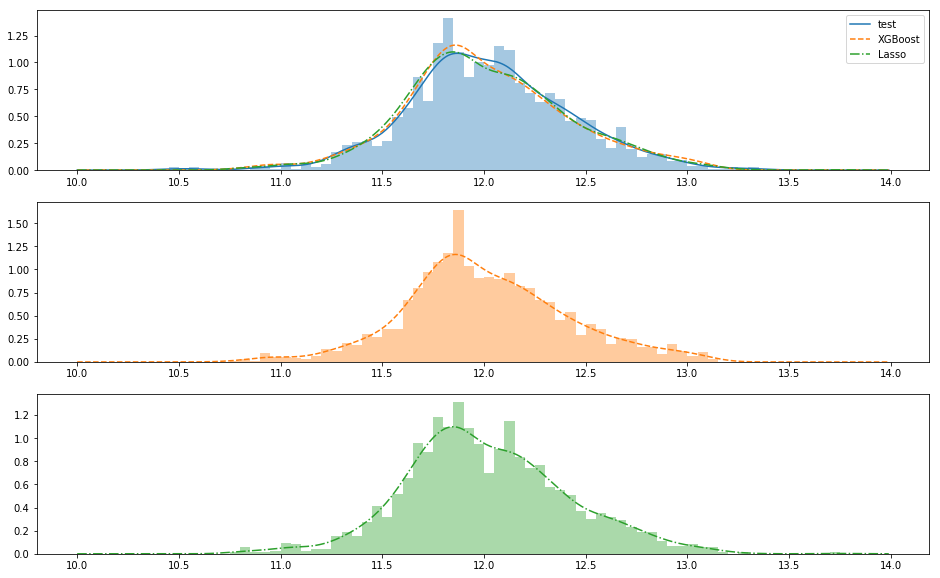

In [130]:
import scipy.stats as stats
# non-parametric pdf
base_kde = stats.kde.gaussian_kde(y_test.SalePrice.values.ravel())
x = np.arange(10, 14, 0.01)
base_kde = base_kde(x)

xgb_kde = stats.kde.gaussian_kde(y_pred_xgb.ravel())
xgb_kde = xgb_kde(x)

#pd.DataFrame({"A":y_pred_lasso}).describe()
lasso_kde = stats.kde.gaussian_kde(y_pred_lasso.ravel())
lasso_kde = lasso_kde(x)

bins = np.arange(10, 14, 0.05)

fig, ax = plt.subplots(3,1, figsize=(16,10))
ax = ax.reshape(3)
ax[0].hist(y_test.SalePrice.values, bins=bins, density=True, alpha=0.4)
ax[0].plot(x, base_kde, 'C0-', label='test')
ax[0].plot(x, xgb_kde, 'C1--', label='XGBoost')
ax[0].plot(x, lasso_kde, 'C2-.', label='Lasso')
ax[0].legend()

ax[1].hist(y_pred_xgb, bins=bins, density=True, color='C1', alpha=0.4)
ax[1].plot(x, xgb_kde, 'C1--', label='XGBoost')

ax[2].hist(y_pred_lasso, bins=bins, density=True, color='C2', alpha=0.4)
ax[2].plot(x, lasso_kde, 'C2-.', label='Lasso')

In [122]:
print("XGBoost KDE-error:",np.linalg.norm(base_kde-xgb_kde)/np.linalg.norm(base_kde))
print("Lasso KDE-error:",np.linalg.norm(base_kde-lasso_kde)/np.linalg.norm(base_kde))

XGBoost KDE-error: 0.07076261347525947
Lasso KDE-error: 0.07377006207199936


In [54]:
print("XGBoost score on training set: ", rmse_xgb)
print("Lasso score on training set: ", rmse_lasso)

XGBoost score on training set:  0.0670828729332519
Lasso score on training set:  0.10155983007006424


## Ensemble model: a blind linear combo of regressors ... why???

In [137]:
# Blend the results of the two regressors and save the prediction to a CSV file.
y_blend = (y_pred_xgb + y_pred_lasso) / 2
y_blend = np.random.choice(y_blend, size=1456, replace=False)

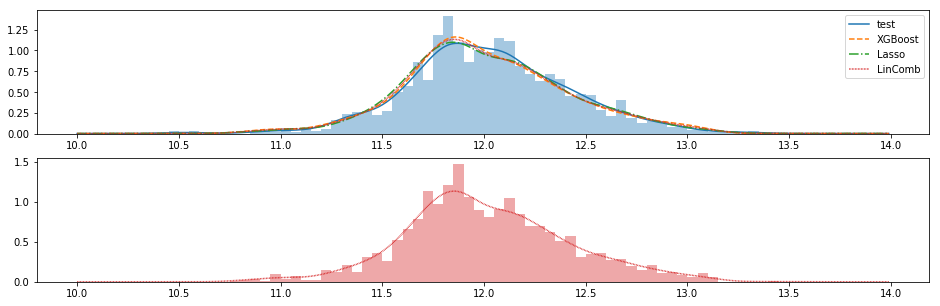

In [139]:
blend_kde = stats.kde.gaussian_kde(y_blend.ravel())
blend_kde = blend_kde(x)

fig, ax = plt.subplots(2,1, figsize=(16,5))
ax = ax.reshape(2)
ax[0].hist(y_test.SalePrice.values, bins=bins, density=True, alpha=0.4)
ax[0].plot(x, base_kde, 'C0-', label='test')
ax[0].plot(x, xgb_kde, 'C1--', label='XGBoost')
ax[0].plot(x, lasso_kde, 'C2-.', label='Lasso')
ax[0].plot(x, blend_kde, 'C3:', dashes = [0.5,0.5], label='LinComb')
ax[0].legend()

ax[1].hist(y_blend, bins=bins, density=True, color='C3', alpha=0.4)
ax[1].plot(x, blend_kde, 'C3:', dashes = [0.5,0.5], label='LinComb');

In [140]:
print("Lasso KDE-error:",np.linalg.norm(base_kde-blend_kde)/np.linalg.norm(base_kde))

Lasso KDE-error: 0.06969159288484969


In [88]:
print("Blend score on training set: ", rmse(y_test, y_blend))
y_blend = np.exp(y_blend)
print("Blend score on training set: ", rmse(y_test, y_blend))

Blend score on training set:  0.5547401222599372
Blend score on training set:  194639.05288408123


```
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('output.csv', header=True, index_label='Id')
```